In [1]:
from model import DenoisingUNet
from utils import *
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
sampleRate = 49.95

In [2]:
N_sub = 11
batch_size = 32
hidden_layers = 6
learning_rate = 5e-6


## Load Test Data

In [3]:
test_path = "validation-events"
test_files = glob(os.path.join(test_path, '*.npy'))

In [4]:
test_files

['validation-events\\event_20211019_053300.851.h5.npy',
 'validation-events\\event_20211019_123212.140.h5.npy',
 'validation-events\\event_20211019_195942.140.h5.npy',
 'validation-events\\event_20211019_200142.140.h5.npy',
 'validation-events\\event_20211019_200812.140.h5.npy',
 'validation-events\\event_20211019_204212.140.h5.npy',
 'validation-events\\event_20211019_204312.140.h5.npy',
 'validation-events\\event_20211019_205342.140.h5.npy',
 'validation-events\\event_20211019_205912.140.h5.npy',
 'validation-events\\event_20211019_211912.140.h5.npy',
 'validation-events\\event_20211019_213512.140.h5.npy',
 'validation-events\\event_20211019_214742.140.h5.npy',
 'validation-events\\event_20211020_013012.140.h5.npy',
 'validation-events\\event_20211020_024412.140.h5.npy',
 'validation-events\\event_20211020_035112.140.h5.npy',
 'validation-events\\event_20211020_231649.084.h5.npy',
 'validation-events\\event_20211021_081249.084.h5.npy',
 'validation-events\\event_20211027_124245.727.h

## Load Trained Model

In [5]:
criterion = nn.MSELoss()
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/yo-more-data-2.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();

## Get J-Invariant Reconstructions

In [6]:
#select a file:
file = test_files[15]
print(file)
eval_sample = np.load(file)
N_ch = eval_sample.shape[0]
N_t = eval_sample.shape[1]

""" Prepare samples and masks """
masks = np.ones((N_ch, N_sub, N_t))
eval_samples = np.zeros_like(masks)

gutter = N_sub // 2
mid = N_sub // 2

for i in range(gutter):
    masks[i, i] = 0
    eval_samples[i, :, :] = eval_sample[:N_sub]

for i in range(gutter, N_ch - gutter):
    start = i - mid
    stop = i + mid if N_sub % 2 == 0 else i + mid + 1

    masks[i, mid] = 0
    eval_samples[i, :, :] = eval_sample[start:stop]

for i in range(N_ch - gutter, N_ch):
    masks[i, i - N_ch] = 0
    eval_samples[i, :, :] = eval_sample[-N_sub:]

sample = eval_samples * masks
sample = torch.unsqueeze(torch.Tensor(sample).squeeze(), 1)
c_mask = (1-masks)
output = model(sample).detach().squeeze()*c_mask
output = output.sum(axis=1)
output_ = taper_filter(output, 1, 10, sampleRate)


validation-events\event_20211020_231649.084.h5.npy


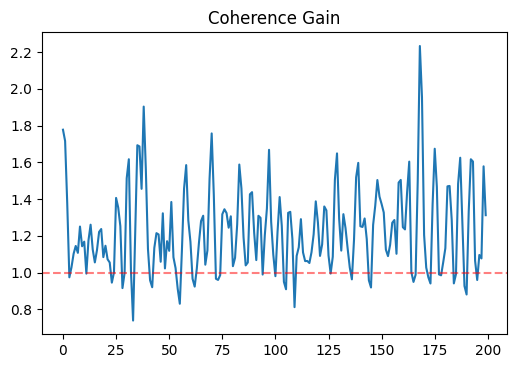

In [15]:
og = np.array(eval_sample)
rec = np.array(output_)
bin_size = 5
cc_og = compute_moving_coherence(og, bin_size)
cc_rec = compute_moving_coherence(rec, bin_size)
cc_gain = cc_rec / cc_og
plt.figure(dpi=100)
plt.plot(cc_gain)
plt.title("Coherence Gain")
plt.axhline(y=1,linestyle='--',alpha=0.5,color='r')

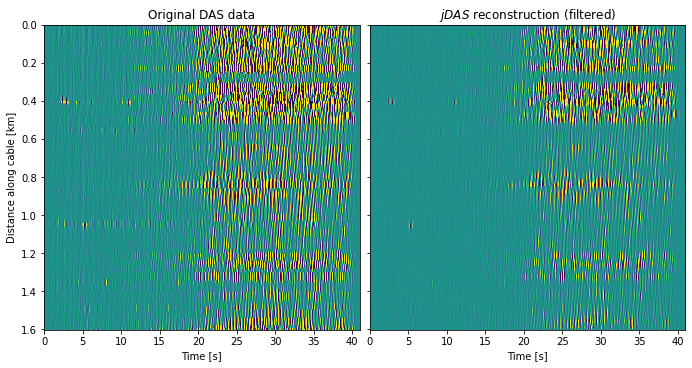

In [8]:
Nch, Nt = eval_sample.shape
gauge = 8.
samp = 50.
dist = np.arange(Nch) * gauge * 1e-3
t = np.arange(Nt) / samp
# Plotting parameters
imshow_kwargs = {
    "interpolation": "antialiased",
    "aspect": "auto",
    "vmin": -0.5,
    "vmax": 0.5,
    "extent": [t.min(), t.max(), dist.max()+1e-2, dist.min()],
}

# Close all other figures
plt.close("all")
# Draw the canvas (2 columns)
fig, axes = plt.subplots(ncols=2, figsize=(9.5, 5), constrained_layout=True, sharey="all")

# Loop over columns and data sets (original and denoised data)
for ax, d, title in zip(axes, (eval_sample,output_), ("Original DAS data", "$jDAS$ reconstruction (filtered)")):
    ax.imshow(d, **imshow_kwargs)
    ax.set_xlabel("Time [s]")
    ax.set_title(title)
    
axes[0].set_ylabel("Distance along cable [km]")

plt.show()

## Wiggle for wiggle comparison

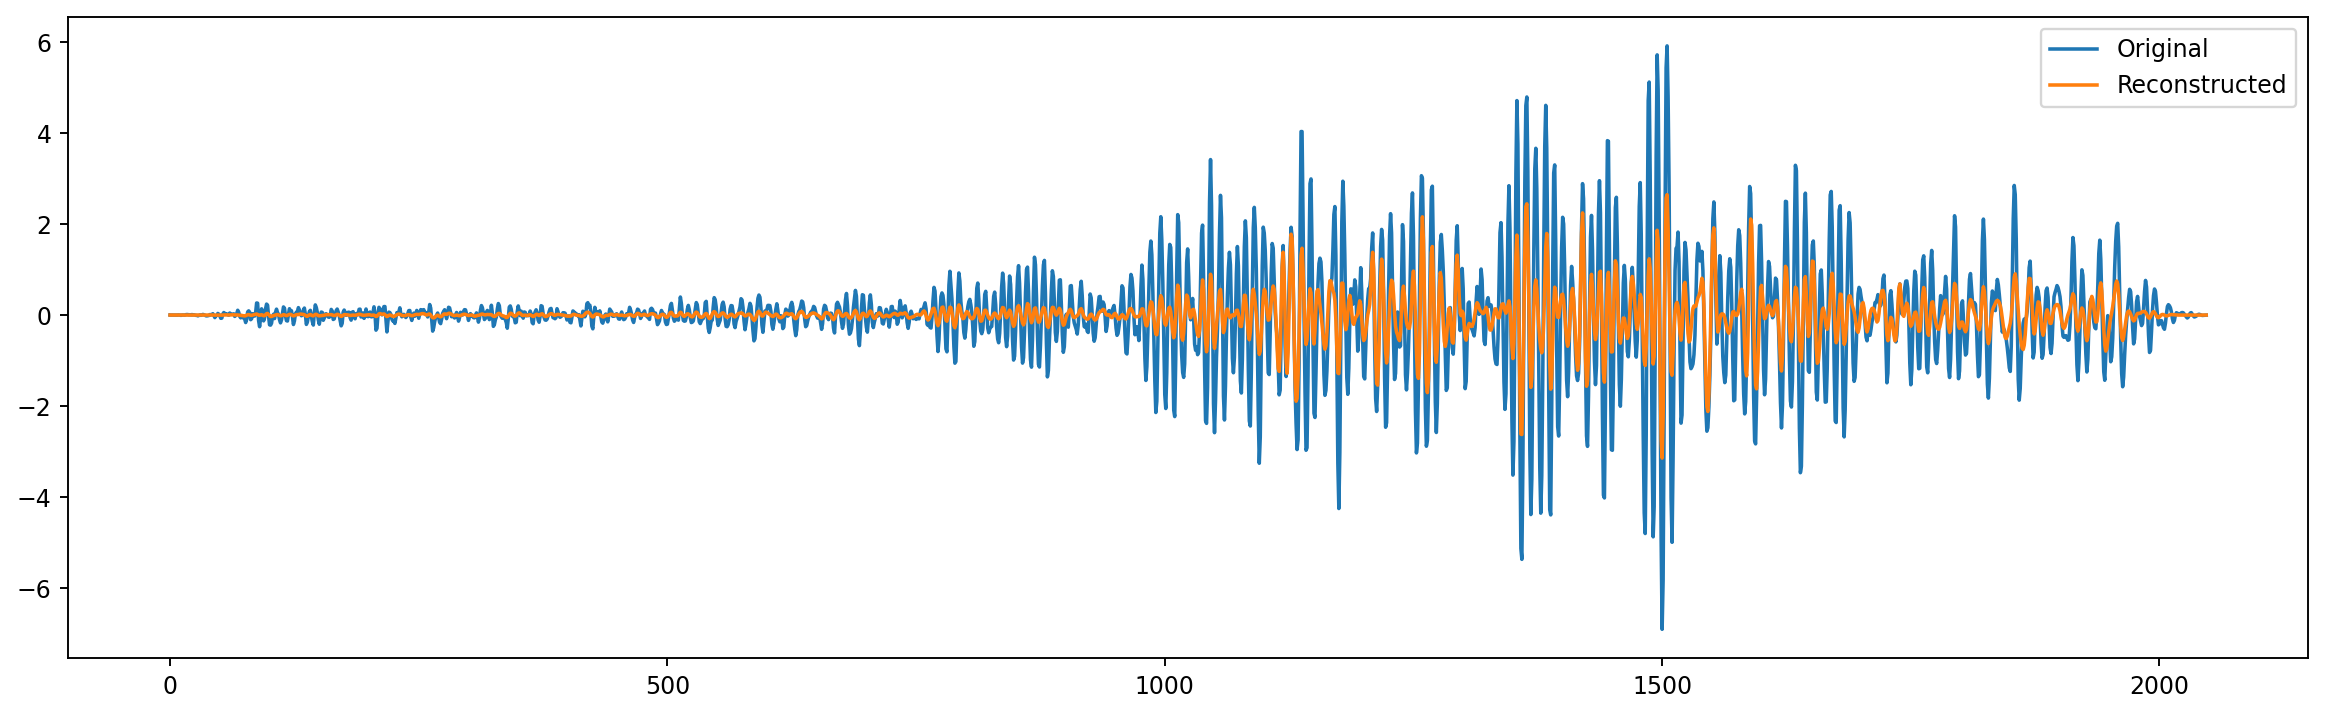

In [9]:
channel=20
plt.figure(figsize=(17,5),dpi=170)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()

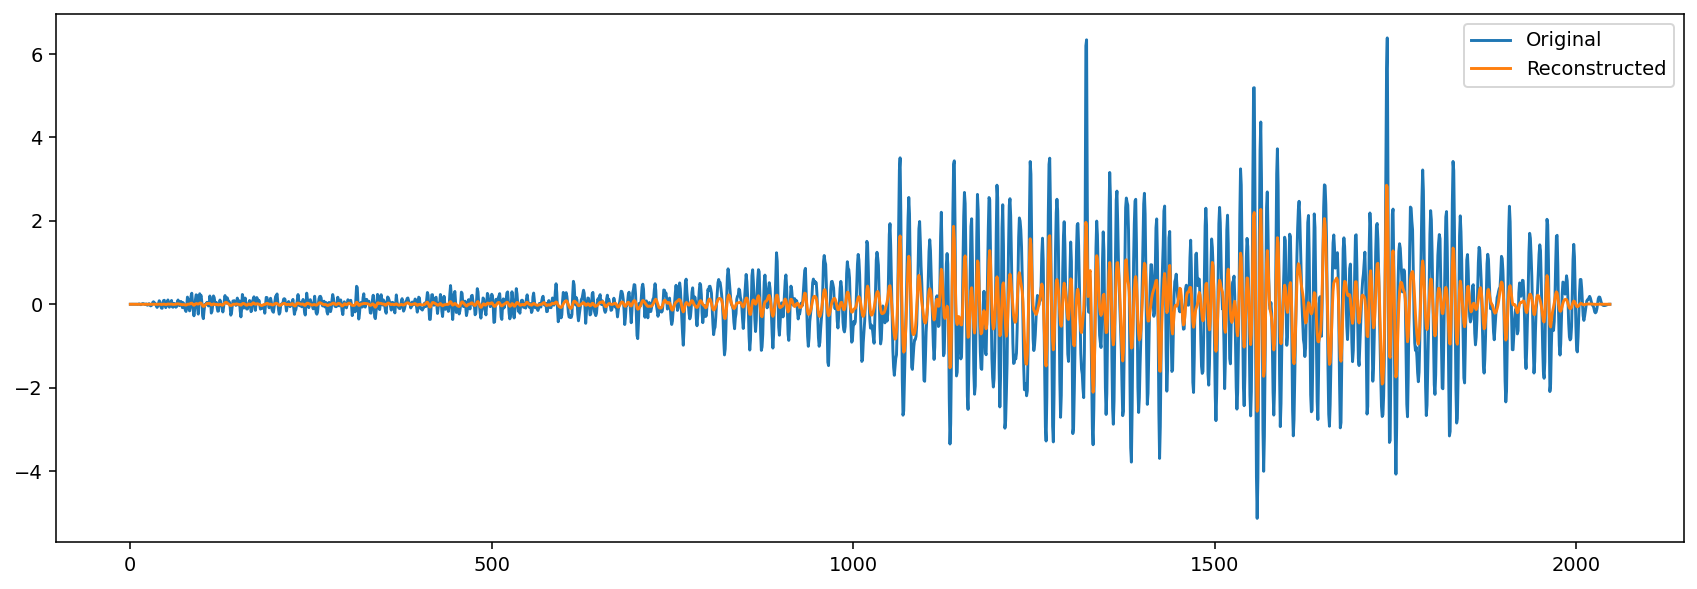

In [25]:
channel=155
plt.figure(figsize=(15,5),dpi=140)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()